In [40]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

### 5.1 A first differential equation
$$ \frac{\mathrm{d}y}{\mathrm{d}t} = 0.9y^2\cos(t) $$
Solution:
$$ y(t) = \frac{10y^{(0)}}{10-9y^{(0)}(\sin(t)-\sin(t^{(0)}))} $$

In [41]:
x0 = torch.zeros((1, 1), requires_grad=True)
y0_target = torch.ones((1, 1))
def f_solution(xs, x0, y0):
    numerator = 10*y0
    denominator = 10 - 9*y0*(np.sin(xs)-np.sin(x0))
    return numerator/denominator

### 5.2 The model with derivative
a) Write a Pytorch model that implements calculating a function and its derivative based on a fully connected feed forward linear model with activation.

In [42]:
class PhysicsInformed(nn.Module):
    def __init__(self, N_hidden_depth=2, N_hidden_width=8):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, N_hidden_width),
            torch.nn.SiLU(),
            *[action for action_pair in \
              [(torch.nn.Linear(N_hidden_width, N_hidden_width), torch.nn.SiLU(),) for _ in range(N_hidden_depth - 1)] \
              for action in action_pair],
            torch.nn.Linear(N_hidden_width, 1))
        self.N_epochs_trained = 0
    
    def forward(self, x):
        return self.layers(x)
    
    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]
        return prediction, derivative

model = PhysicsInformed(N_hidden_depth=2, N_hidden_width=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

### 5.3 Loss function
$$ \mathcal{L} = \left|y_\theta(t^{(0)})-y^{(0)}\right|^2 + \frac{1}{N_\mathrm{random}}\sum_i\left|\frac{\mathrm{d}y_\theta}{\mathrm{d}t}\Bigg|_{t_i} -0.9y_\theta^2(t_i)\cos(t_i)\right|^2 $$

### 5.4 Training

In [43]:
def train_pinn(x0, y0_target, epochs=2500, xmin=0, xmax=5):
    for epoch in tqdm(range(epochs), desc='Training'):
        y0_predicted, _ = model.prediction_and_derivative(x0)
        loss = criterion(y0_predicted, y0_target)

        xs = torch.rand((32, 1), requires_grad=True)*(xmax - xmin) + xmin
        y, dydx = model.prediction_and_derivative(xs)
        loss += criterion(dydx, 0.9 * y**2 * torch.cos(xs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.N_epochs_trained += 1

Training: 100%|██████████| 90000/90000 [03:58<00:00, 378.14it/s]


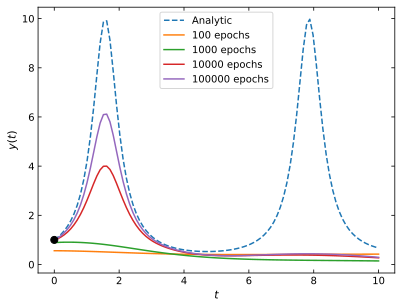

In [44]:
fig, ax = plt.subplots()
domain = [0, 10]
xs = torch.linspace(*domain, 100).reshape(-1, 1)
xsnp = xs.detach().numpy()
ax.plot(xsnp, f_solution(xsnp, x0.item(), y0_target.item()), ls='--', label='Analytic')

for epochs_to_train in [100, 900, 9000, 90000]:
    train_pinn(x0, y0_target, epochs=epochs_to_train, xmin=domain[0], xmax=domain[1])
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs')

ax.legend()
ax.set(xlabel='$t$', ylabel='$y(t)$')
ax.scatter(x0.item(), y0_target.item(), s=50, c='k', zorder=10)

fig.savefig('ex64_fig1.png')

In [45]:
xs_boundary = torch.tensor([1.09491408, 2.04667858, 7.37809938, 8.32986388], dtype=torch.float32, requires_grad=True).reshape(-1, 1)
ys_boundary = torch.tensor([5]*4, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
def modified_train_pinn(x0, y0_target, epochs=2500, xmin=0, xmax=5):
    for epoch in tqdm(range(epochs), desc='Training'):
        y0_predicted, _ = model.prediction_and_derivative(xs_boundary)
        loss = criterion(y0_predicted, ys_boundary)

        xs = torch.rand((32, 1), requires_grad=True)*(xmax - xmin) + xmin
        y, dydx = model.prediction_and_derivative(xs)
        loss += criterion(dydx, 0.9 * y**2 * torch.cos(xs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.N_epochs_trained += 1

Training: 100%|██████████| 90000/90000 [02:36<00:00, 575.12it/s]


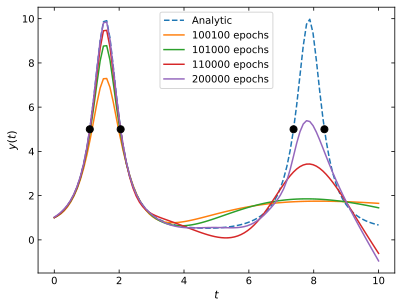

In [46]:
fig, ax = plt.subplots()
domain = [0, 10]
xs = torch.linspace(*domain, 100).reshape(-1, 1)
xsnp = xs.detach().numpy()
ax.plot(xsnp, f_solution(xsnp, x0.item(), y0_target.item()), ls='--', label='Analytic')

for epochs_to_train in [100, 900, 9000, 90000]:
    modified_train_pinn(x0, y0_target, epochs=epochs_to_train, xmin=domain[0], xmax=domain[1])
    ys = model(xs)
    ax.plot(xs.detach(), ys.detach(), label=f'{model.N_epochs_trained} epochs')

ax.legend()
ax.set(xlabel='$t$', ylabel='$y(t)$')
ax.scatter(xs_boundary.detach(), ys_boundary.detach(), s=50, c='k', zorder=10)

fig.savefig('ex64_fig2.png')